<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузим-данные" data-toc-modified-id="Загрузим-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузим данные</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-даных" data-toc-modified-id="Предобработка-даных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка даных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#вывод" data-toc-modified-id="вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>вывод</a></span></li></ul></div>

# Модель классификации комментариев для интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть, клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Значение метрики качества *F1* у модели должно быть не меньше 0.75. 



# **Цель**: 
   * Обучить модель классифицировать комментарии на позитивные и негативные
<br>

# **Задача**: 
   * Получить значение метрики качества F1 у модели не меньше 0.75
<br>

# **Описание данных**: 

   * Данные находятся в файле /datasets/toxic_comments.csv.
   * Столбец text содержит текст комментария, а toxic — целевой признак.

<br>


# **План работы**:
   * Загрузка данных
   * Анализ данных
   * Деление датасета на выборки: тренировочная и тестовая  в пропорции 90:10
   * Подбор параметров моделей, для минимизации F1
   * Анализ полученных результатов
   * Общий вывод
    



# Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords, wordnet
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

import time
import re
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tito_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tito_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tito_\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tito_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\tito_\anaconda3\envs\praktikum_env_win_new\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

### Загрузим данные

In [21]:
# Загрузка данных
pth1 = 'datasets/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print("Проверьте правильность пути к датасету")

In [22]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


### Анализ данных

In [23]:
# в датасете два столбца, один с текстом, второй с целевым признаком
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [24]:
# Пропуски
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Пропуски отсутствуют

In [25]:
# Дубликаты
data.duplicated().sum()

0

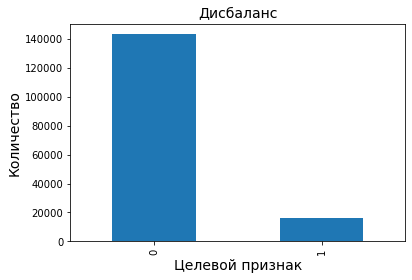

In [26]:
# Посмотрим дисбаланс целевого признака
data['toxic'].value_counts().plot(kind='bar')
plt.title("Дисбаланс", fontsize=14)
plt.xlabel("Целевой признак", fontsize=14)
plt.ylabel("Количество", fontsize=14)
plt.show()

Дисбаланс в наличии: плохих комментариев меньше хороших

### Вывод

* Данные загружены успешно, в датасете два столбца: один с тестами, второй с целевым признаком
* Пропусков и дубликатов нет
* Наблюдается дисбаланс по целевому признаку

## Предобработка даных

# Очиста текста

In [27]:
# функция очистки текстов
def clear_text(text):
    re_list = re.sub(r"[^a-zA-Z']", ' ', text)
    re_list = re_list.lower() #добавлено исправление
    re_list = re_list.split()
    re_list = " ".join(re_list)
    return re_list

In [28]:
%%time
data['text'] = data['text'].progress_apply(clear_text)
data

  0%|          | 0/159292 [00:00<?, ?it/s]

Wall time: 12.3 s


,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d'aww he matches this background colour i'm se...,0
2,2,hey man i'm really not trying to edit war it's...,0
3,3,more i can't make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0
...,...,...,...
159287,159446,and for the second time of asking when your vi...,0
159288,159447,you should be ashamed of yourself that is a ho...,0
159289,159448,spitzer umm theres no actual article for prost...,0
159290,159449,and it looks like it was actually you who put ...,0


# Лемматизация


In [29]:
# для англ языка используем лемматизатор Wordnet из NLTK
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


m = WordNetLemmatizer()

def lemmatize(text):
    #добавлено исправление
    word_list = nltk.word_tokenize(text)
    
    return ' '.join([m.lemmatize(w, get_wordnet_pos(w)) for w in word_list])

In [ ]:
%%time
# Лемматизируем текст
data['lemm_text'] = data['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
data

# Корпус и выборки

In [ ]:
# сделаем датасет с лемматизированнымии токенизироанными данными
data_clear = data.drop('text', axis=1)

In [ ]:
# создадим корпус из очищенных текстов
corpus = data_clear['lemm_text'].values

In [ ]:
# сделаем выборки
features = corpus
target = data_clear['toxic'].values

In [ ]:
# разобьем выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)


In [ ]:
print(features_train.shape)
print(features_test.shape)

In [ ]:
# Прогоним через  стоп слова
stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = count_tf_idf.fit_transform(features_train) # < напишите код здесь >
tf_idf_test = count_tf_idf.transform(features_test)

In [ ]:
print(tf_idf_train.shape)
print(tf_idf_test.shape)

### Вывод

* очистили данные
* Сделали токенизацию и лемматизацию
* Сделали тренировочную и тестовую выборки для последующего обучения моделей
* Из выборок удалили стоп слова

# Обучение

In [ ]:
# Функция обучения и предсказания, на вход принимает алгоритм, признаки, целевой признак и параметры
# принимает на вход название алгоритма, признаки, целевой признак и параметры для Grid
# В параметрах можно задать перебор
# возвращает словарь с данными о времени обучения и rmse
def fit_predict(algo, X_train, y_train, X_test, y_test, parametrs):


#     if algo == LinearRegression:
#         model_grid = algo()

#     else:
    model = algo()
    #Добавлено исправление
    
    # надо посмотреть, как подобрать параметр и аргументировать
#     tscv = TimeSeriesSplit(n_splits=8)
    model_grid = GridSearchCV(model, n_jobs=-1, param_grid=parametrs, scoring='f1', cv=5)
    #Добавлено исправление
    
    start_fit = time.time()
    model_grid_best = model_grid.fit(X_train, y_train)
    print(model_grid_best.best_params_)
    stop_fit = time.time()
    start_pred_test =  time.time()
    predicted_test = model_grid_best.predict(X_test)
    stop_pred_test = time.time()
    f1_test = f1_score(y_test, predicted_test) ** 0.5

    start_pred_train =  time.time()
    predicted_train = model_grid_best.predict(X_train)
    stop_pred_train = time.time()
    f1_train = f1_score(y_train, predicted_train) ** 0.5

    time_fit = stop_fit - start_fit
    time_predict_test = stop_pred_test - start_pred_test
    time_predict_train = stop_pred_train - start_pred_train
    algo = str(algo).split(sep='.')

    algo = re.sub("[^A-Za-z0-9]",'',str(algo[-1]))
    t = {'algo' : algo,
         'time_fit': round(time_fit, 6),
         'time_predict_train': round(time_predict_train, 6),
         'time_predict_test': round(time_predict_test, 6),
         'f1_train': round(f1_train, 2),
         'f1_test': round(f1_test, 2)
        }
    return t, model_grid_best

# LogisticRegression

In [ ]:
%%time
params = {
#           'normalize': [True, False],
#           'fit_intercept': [True, False],
#           'copy_X': [True, False],
#           'c': [0.1, 1, 10, 100],
           'solver': ['liblinear', 'saga']
         }
lr_result, lr_model = fit_predict(LogisticRegression, tf_idf_train, target_train,tf_idf_test, target_test, params)

# DesicionTreeClassifier

In [ ]:
%%time
params = {'max_depth': range(8,10),
          'random_state': [12345]}
dtr_result, dtr_model = fit_predict(DecisionTreeClassifier, tf_idf_train, target_train,tf_idf_test, target_test, params)

# CatBoostClassifier

In [ ]:
params = {'max_depth': range(5,6),
#           'n_estimators': range(100, 120),
           'random_state': [12345],
#           'learning_rate': np.arange(0.3, 0.9, 0.2)
         }
crb_result, cbr_model = fit_predict(CatBoostClassifier, tf_idf_train, target_train,tf_idf_test, target_test, params)


# LGBMClassifier

In [ ]:
params = {
    'random_state': [12345],    
#     'boosting_type': ['dart'],
#     'objective': ['regression'],
    'force_col_wise': [True],
#     'num_leaves': range(13, 15), 
#     'learning_rate': np.arange(0.3, 0.5, 0.1),
    'bagging_fraction': np.arange(0.6, 0.7, 0.1),
    'verbose':[0]
}
lgbt_result, lgmt_model = fit_predict(LGBMClassifier, tf_idf_train, target_train,tf_idf_test, target_test, params)
lgbt_result

In [ ]:
# запишем все результаты в список

all_data = []

all_data.append(lr_result)
all_data.append(dtr_result)
all_data.append(crb_result)
all_data.append(lgbt_result)

In [ ]:
# Список в пандас
# Сделаем датафрейм и посторим графики
df_all_algo = pd.DataFrame(all_data)

df_all_algo.columns = ['Алгоритм', 'Время обучения', 'Время предсказания train','Время предсказания test' , 'f1 train', 'f1 test']
df_all_algo = df_all_algo.set_index('Алгоритм')
df_all_algo

# f1 Тренировочная выборка

In [ ]:
# f1 тренировочная выборка

df_all_algo['f1 train'].sort_values().plot(kind='bar')
plt.title("", fontsize=20)
plt.xlabel("Алгоритм", fontsize=20)
plt.ylabel("f1 train", fontsize=20)
plt.legend('')
plt.show()

# * По итогам работы обученных моделей можно сделать вывод:
   * Самую лучшую метрику f1 на тренировочной выборке показал алгоритм LGBMregressor, на втором месте CatBoostregressor
   * На тестовой выборке эти два алгоритма также проявили себя хорошо, показав результаты выше требуемого 75. RMSE у алгоритма LogisticRegression = 0.85, у DecisionTreeClassifier = 0.76


## вывод

В ходе работы над проектом было сделано:

* Подгружены и проверены данные
* Произведена очистка и лемматизация данных
* Подобраны лучшие параметры для 4х моделей : LogisticRegersion, CatBoostClassifier, DecisionTreeClassifier и LGBMClassifier
* Результаты метрики F1 по моделям свели для анализа в одну таблицу.
* Лучшие показатели по метрике F1 у модели LGBMRegressor и равен 0.86

